## Inspecting and preprocessing the data before training

In [44]:
# import the packages
import os
import pandas as pd
import numpy as np
import torchaudio
import torch 

import IPython.display as ipd
import matplotlib.pyplot as plt
import re
import json

from utils import *

In [26]:
#define directories 
current_dir = os.getcwd() 
songs_path = os.path.join(current_dir, "Dataset\\songs\\songs") 
spectrograms_path = os.path.join(current_dir, "Dataset\\spectrograms") 
relative_proccessed_song_path = "Dataset\\preprocessed_songs" #needed to save the relative paths of the preprocessed audio files
preprocessed_songs_path = os.path.join(current_dir, relative_proccessed_song_path) 

In [27]:
#load the metadata dataframe 
file_name = "Dataset\\birdsong_metadata.csv"
file_path = os.path.join(current_dir, file_name) 

df_birdsongs_metadata = pd.read_csv(file_path)
display(df_birdsongs_metadata)

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/


In [28]:
unique_bird_names = set(df_birdsongs_metadata["english_cname"])
print("Birds: ", unique_bird_names)
print("Number of unique birds: ", len(unique_bird_names))

Birds:  {'Eurasian Skylark', 'Goldcrest', 'Willow Ptarmigan', 'Redwing', 'Meadow Pipit', 'Lesser Whitethroat', 'European Turtle Dove', 'Stock Dove', 'Western Jackdaw', 'River Warbler', 'Dunnock', 'Common Reed Bunting', 'Wood Sandpiper', 'Northern Raven', 'Common Chiffchaff', 'Garden Warbler', 'European Honey Buzzard', 'European Golden Plover', 'Corn Bunting', 'Grey Plover', 'Willow Warbler', 'Red Crossbill', 'Tree Pipit', 'European Nightjar', 'Tawny Owl', 'Eurasian Collared Dove', 'House Sparrow', 'Eurasian Blue Tit', 'Yellowhammer', 'Eurasian Wren', 'Common Linnet', 'Black-headed Gull', 'Black Woodpecker', 'Eurasian Jay', 'Eurasian Golden Oriole', 'Dunlin', 'Spotted Flycatcher', 'Great Spotted Woodpecker', 'Marsh Warbler', 'Common Snipe', 'Eurasian Oystercatcher', 'Coal Tit', 'Common Pheasant', 'Northern Lapwing', 'Eurasian Treecreeper', 'Eurasian Coot', 'Rock Dove', 'Common House Martin', 'Eurasian Tree Sparrow', 'African Pied Wagtail', 'Sedge Warbler', 'Wood Warbler', 'Red-throated 

### Visualizing the audio signal

In [34]:
#using the first bird in the bird metadata df
# sound_file = "xc132608.flac"
# sound_file = "xc132611.flac"
sound_file = "xc35068.flac"

sound_file_path = os.path.join(songs_path, sound_file)
#check if the path exists
print(os.path.isfile(sound_file_path))

True


Shape of waveform: torch.Size([1, 223488])
Sample rate of waveform: 44100
Audio duration: 5.07 seconds


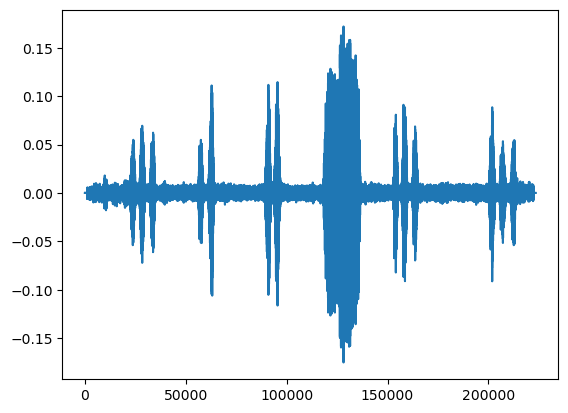

In [40]:
#load the audio data
waveform, sample_rate = torchaudio.load(sound_file_path)
#print some information about the signal
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
duration_in_seconds = round(waveform.size()[1] / sample_rate, 2)
print(f"Audio duration: {duration_in_seconds} seconds")

#plot the signal
plt.figure()
plt.plot(waveform.t().numpy())
#listen to the audio
ipd.Audio(waveform.numpy(), rate=sample_rate)

Chunk 1: Duration 5.00 seconds


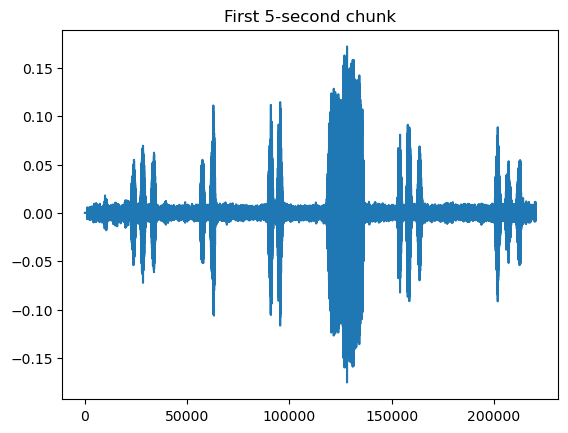

In [41]:
#split the audio into 5 second chuncks
waveform_chunks = AudioUtil.split_audio_into_chunks(waveform=waveform, sample_rate=sample_rate, 
                                          chunk_duration_s = 5.0, padded=True)

# Display information about the chunks
for i, chunk in enumerate(waveform_chunks):
    chunk_duration = chunk.size(1) / sample_rate
    print(f"Chunk {i + 1}: Duration {chunk_duration:.2f} seconds")

# Display the first chunk
plt.figure()
plt.plot(waveform_chunks[-1].t().numpy())
plt.title('First 5-second chunk')

# Listen to the first chunk
ipd.Audio(waveform_chunks[-1].numpy(), rate=sample_rate)


Shape of spectrogram: torch.Size([1, 401, 552])


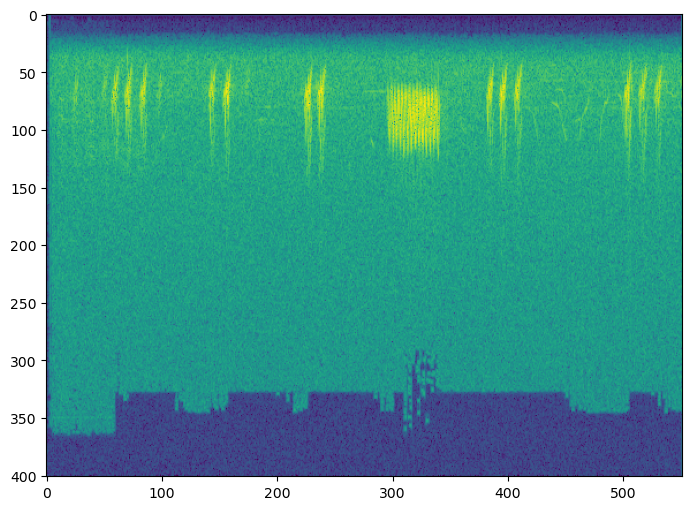

In [42]:
#create the spectrogram (frequency vs time)
transform = torchaudio.transforms.Spectrogram(n_fft=800, hop_length=400, win_length=800, center=True)
# test_spectrogram = transform(waveform)
test_spectrogram = transform(waveform_chunks[-1])

test_spectrogram = torchaudio.transforms.AmplitudeToDB()(test_spectrogram)

print("\nShape of spectrogram: {}".format(test_spectrogram.size()))

plt.figure(figsize=(10, 6))
plt.imshow(test_spectrogram[0,:,:].numpy())
plt.imshow(test_spectrogram.log2()[0,:,:].numpy(), cmap='viridis')

### Split the dataset into chunks of 5s audio clips 
Split each audio file into 5 second clips to have a consistent input size for the model. \
For each clip put an entry into the data frame: 
file_id, original_file_id, english_cname, relative_path, class_id

In [43]:
#load the class id to name mapping
dict_file_path = "Dataset\\class_id_to_name_mapping.json"
with open(dict_file_path, "r") as file: 
    load_dict = json.load(file)
    #convert the keys to integers
    class_id_to_name_dict = {int(key): value for key, value in load_dict.items()}

#create bird name to class id mappig
name_to_class_id_dict = {value: key for key, value in class_id_to_name_dict.items()}
print(name_to_class_id_dict)

{'Long-tailed Tit': 0, 'Eurasian Golden Oriole': 1, 'Wood Warbler': 2, 'Lesser Whitethroat': 3, 'Common Starling': 4, 'Eurasian Collared Dove': 5, 'Common Reed Bunting': 6, 'Common Linnet': 7, 'Yellowhammer': 8, 'Western Yellow Wagtail': 9, 'Wood Sandpiper': 10, 'Garden Warbler': 11, 'Spotted Flycatcher': 12, 'Goldcrest': 13, 'Eurasian Wryneck': 14, 'Common Redshank': 15, 'River Warbler': 16, 'European Honey Buzzard': 17, 'Eurasian Bullfinch': 18, 'Rock Dove': 19, 'Dunlin': 20, 'African Pied Wagtail': 21, 'Sedge Warbler': 22, 'Eurasian Magpie': 23, 'Redwing': 24, 'Common Pheasant': 25, 'Common Chaffinch': 26, 'Willow Warbler': 27, 'Western Jackdaw': 28, 'Common Chiffchaff': 29, 'Great Tit': 30, 'Corn Bunting': 31, 'Eurasian Skylark': 32, 'Common Nightingale': 33, 'European Greenfinch': 34, 'Eurasian Reed Warbler': 35, 'European Herring Gull': 36, 'Eurasian Jay': 37, 'Common Blackbird': 38, 'Black-headed Gull': 39, 'Willow Ptarmigan': 40, 'Eurasian Treecreeper': 41, 'Black Woodpecker': 

In [30]:
#row: id, original id, english_cname, relative_path
id_list = []
original_id_list = []
english_cname_list = []
relative_path_list = []

#get all audio files 
audio_files = os.listdir(songs_path)

#regular expression pattern to extract the number after "xc"
pattern = re.compile(r'xc(\d+)\.flac')

#loop through each file
counter = 1
for file_name in audio_files:
    match = pattern.match(file_name)
    #if file matches the expected filename
    if match:
        extracted_number = int(match.group(1))
        
        #load the audio file 
        file_path = os.path.join(songs_path, file_name) 
        waveform, sample_rate = torchaudio.load(file_path)

        #split the audio into 5 second chunks
        waveform_chunks = AudioUtil.split_audio_into_chunks(waveform=waveform, sample_rate=sample_rate, 
                                                  chunk_duration_s = 5.0, padded=True)

        print(f"Filename: {file_name}, Number of chunks: {len(waveform_chunks)}")
        
        #save each chunk
        for waveform_chunk in waveform_chunks: 
            id_list.append(counter)
            original_id_list.append(extracted_number)
            english_cname_list.append(df_birdsongs_metadata.loc[df_birdsongs_metadata['file_id'] == extracted_number,'english_cname'].values[0])
            chunk_file_name = f"{counter}.flac"
            relative_chunk_path = os.path.join(relative_proccessed_song_path, chunk_file_name)
            relative_path_list.append(relative_chunk_path)

            #save chunk 
            torchaudio.save(chunk_path, waveform_chunk, sample_rate)
            # print("Audio saved at:", chunk_path)
            counter += 1
    else: 
        print(f"File: {file_name} did not match")

data_dict = {
    "file_id": id_list, 
    "original_file_id": original_id_list, 
    "english_cname": english_cname_list, 
    "relative_path": relative_path_list,
}

#convert the dictionary to a pandas DataFrame
df_metadata = pd.DataFrame(data_dict)

#add class id to dataframe
df_metadata['class_id'] = df_metadata['english_cname'].map(name_to_class_id_dict)

#save metadata dataframe
file_name = "Dataset\\metadata.csv"
file_path = os.path.join(current_dir, file_name) 
df_metadata.to_csv(file_path, index=False)

Filename: xc101371.flac, Number of chunks: 5
Filename: xc101377.flac, Number of chunks: 15
Filename: xc101862.flac, Number of chunks: 14
Filename: xc101932.flac, Number of chunks: 4
Filename: xc101933.flac, Number of chunks: 4
Filename: xc101934.flac, Number of chunks: 6
Filename: xc101935.flac, Number of chunks: 11
Filename: xc101936.flac, Number of chunks: 5
Filename: xc101940.flac, Number of chunks: 14
Filename: xc101941.flac, Number of chunks: 5
Filename: xc102048.flac, Number of chunks: 5
Filename: xc102060.flac, Number of chunks: 31
Filename: xc102106.flac, Number of chunks: 5
Filename: xc102107.flac, Number of chunks: 18
Filename: xc102278.flac, Number of chunks: 6
Filename: xc102788.flac, Number of chunks: 22
Filename: xc102803.flac, Number of chunks: 9
Filename: xc102868.flac, Number of chunks: 5
Filename: xc102869.flac, Number of chunks: 10
Filename: xc102932.flac, Number of chunks: 19
Filename: xc103145.flac, Number of chunks: 7
Filename: xc106846.flac, Number of chunks: 16


In [31]:
# Display the DataFrame
display(df_metadata)

,file_id,original_file_id,english_cname,relative_path,class_id
0,1,101371,Long-tailed Tit,Dataset\preprocessed_songs\1.flac,0
1,2,101371,Long-tailed Tit,Dataset\preprocessed_songs\2.flac,0
2,3,101371,Long-tailed Tit,Dataset\preprocessed_songs\3.flac,0
3,4,101371,Long-tailed Tit,Dataset\preprocessed_songs\4.flac,0
4,5,101371,Long-tailed Tit,Dataset\preprocessed_songs\5.flac,0
...,...,...,...,...,...
3543,3544,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3544.flac,75
3544,3545,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3545.flac,75
3545,3546,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3546.flac,75
3546,3547,99937,Eurasian Nuthatch,Dataset\preprocessed_songs\3547.flac,75


### Creating frequency domain plot for every bird 

In [21]:
proccessed_birds = []

#folder for frequency plots 
plots_folder = "Dataset\\freq_plots"
plots_folder_path = os.path.join(current_dir, plots_folder)  

#get all audio files 
audio_files = os.listdir(songs_path)

#regular expression pattern to extract the number after "xc"
pattern = re.compile(r'xc(\d+)\.flac')

#loop through each file
for file_name in audio_files:
    match = pattern.match(file_name)
    #if file matches the expected filename
    if match:
        extracted_number = int(match.group(1))
        bird_name = df_birdsongs_metadata.loc[df_birdsongs_metadata['file_id'] == extracted_number,'english_cname'].values[0]

        if bird_name not in proccessed_birds: 
            plot_title = bird_name + " Frequency Domain Plot"
            proccessed_birds.append(bird_name)
        
            #load the audio file 
            file_path = os.path.join(songs_path, file_name) 
            waveform, sample_rate = torchaudio.load(file_path)
            
            #create the plot 
            ### Compute the Fourier Transform
            fft_result = torch.fft.rfft(waveform)
            
            # Compute the magnitudes of the complex values
            magnitude = torch.abs(fft_result)
            
            # Create a frequency axis
            frequency_axis = torch.fft.rfftfreq(waveform.size(1), d=1.0/sample_rate)
            
            # Display the frequency domain plot
            plt.figure(figsize=(10, 4))
            plt.plot(frequency_axis.numpy(), magnitude.numpy()[0])
            plt.title(plot_title)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Magnitude')
            plt.grid(True)
            # plt.show()

            #save the plot 
            plot_filename = os.path.join(plots_folder_path, bird_name + '_frequency_plot.png')
            plt.savefig(plot_filename)
            plt.close()  # Close the plot to release resources

            print(f"Created: {plot_title}")
    else: 
        print(f"File: {file_name} did not match")



Created: Long-tailed Tit Frequency Domain Plot
Created: Eurasian Golden Oriole Frequency Domain Plot
Created: Wood Warbler Frequency Domain Plot
Created: Lesser Whitethroat Frequency Domain Plot
Created: Common Starling Frequency Domain Plot
Created: Eurasian Collared Dove Frequency Domain Plot
Created: Common Reed Bunting Frequency Domain Plot
Created: Common Linnet Frequency Domain Plot
Created: Yellowhammer Frequency Domain Plot
Created: Western Yellow Wagtail Frequency Domain Plot
Created: Wood Sandpiper Frequency Domain Plot
Created: Garden Warbler Frequency Domain Plot
Created: Spotted Flycatcher Frequency Domain Plot
Created: Goldcrest Frequency Domain Plot
Created: Eurasian Wryneck Frequency Domain Plot
Created: Common Redshank Frequency Domain Plot
Created: River Warbler Frequency Domain Plot
Created: European Honey Buzzard Frequency Domain Plot
Created: Eurasian Bullfinch Frequency Domain Plot
Created: Rock Dove Frequency Domain Plot
Created: Dunlin Frequency Domain Plot
Crea